# Setup

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# Database and schema setup

In [7]:
from sqlalchemy import Column, ForeignKey, Integer, String, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy.sql.expression import extract
from sqlalchemy import create_engine
from datetime import date

Base = declarative_base()
 
class Transaction(Base):
    __tablename__ = 'transaction'
    id = Column(Integer, primary_key=True)
    timestamp = Column(DateTime())
    amount = Column(Integer, nullable=False)
    description = Column(String(250), nullable=False)
    type = Column(Integer, ForeignKey('transaction_type.id'))

class TransactionType(Base):
    __tablename__ = 'transaction_type'
    id = Column(Integer, primary_key=True)
    name = Column(String(250), nullable=False)

engine = create_engine('mysql+pymysql://root:@localhost:3306')
engine.execute("CREATE DATABASE IF NOT EXISTS test")

engine = create_engine('mysql+pymysql://root:@localhost:3306/test')
Base.metadata.create_all(engine)

/usr/lib64/python2.7/site-packages/pymysql/cursors.py:166: Warning: (1007, "Can't create database 'test'; database exists")
  result = self._query(query)


# Insert core data

In [8]:
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
session = DBSession()

tts = [tt.name for tt in session.query(TransactionType).all()]

expense_tt = TransactionType(name="Expense")
if not expense_tt.name in tts:
  session.add(expense_tt)

income_tt = TransactionType(name="Income")
if not income_tt.name in tts:
  session.add(income_tt)

session.commit()

# Insert test data

In [9]:
session = DBSession()

data = np.random.randint(1, 500, size=50);
tt = np.random.randint(0, len(tts), size=50);

expense_descriptions = ['food','fuel','car','flight','accomodation']
incode_description = ['employment','dividends','interest']

tts = session.query(TransactionType).all()

for index, amt in enumerate(data):
    description = ""
    if tts[tt[index]].name == "Expense":
        description = expense_descriptions[np.random.randint(1,len(expense_descriptions))]
    else:
        description = incode_description[np.random.randint(1,len(incode_description))]
    
    trans = Transaction(
      timestamp=date(2016, np.random.randint(1, 4, size=1), np.random.randint(1, 30, size=1)),
      amount=int(amt),
      description=description,
      type = tts[tt[index]].id
    )
    session.add(trans)


session.commit()

# Main chart

[0 1 2]


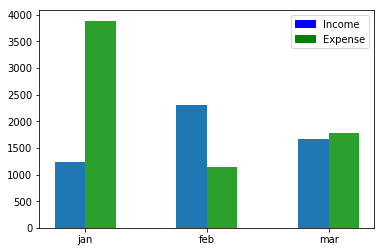

In [26]:
fig, ax = plt.subplots();

plotdata = np.empty([2, 3], dtype=int)

for index, tt in enumerate(["Expense","Income"]):
    for month in [1,2,3]:
        data = session.query(Transaction,TransactionType).join(TransactionType).filter(extract('month', Transaction.timestamp) == month, TransactionType.name == tt).all()
        plotdata[index][month-1] = np.sum([dp.Transaction.amount for dp in data])
            
x = np.arange(3);
print x
y1, y2 = plotdata



width = 0.25;
ax.bar(x, y1, width);
ax.bar(
    x + width,
    y2,
    width,
    color=list(plt.rcParams['axes.prop_cycle'])[2]['color']
)

green_patch = mpatches.Patch(color='green', label='Expense')
blue_patch = mpatches.Patch(color='blue', label='Income')
plt.legend(handles=[blue_patch, green_patch])

ax.set_xticks(x + width/2)
ax.set_xticklabels(['jan', 'feb', 'mar']);